In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import applications
from keras import optimizers

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150
#img_width, img_height = 244, 244

train_data_dir = 'C:\\Users\\rafae\\Downloads\\teste\\data\\train'
validation_data_dir = 'C:\\Users\\rafae\\Downloads\\teste\\data\\val'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [3]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto') 

In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=35,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2001 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


In [5]:
base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height,3))
#base_model = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height,3))

# add a global spatial average pooling layer
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
#x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

In [6]:
#model.compile(optimizer='adam',
#              loss='binary_crossentropy', 
#              metrics=['accuracy'])
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[early_stopping])

Epoch 1/50
125/125 [==============================] - 221s 2s/step - loss: 0.6168 - acc: 0.6590 - val_loss: 0.3541 - val_acc: 0.8712
Epoch 2/50
125/125 [==============================] - 209s 2s/step - loss: 0.3828 - acc: 0.8255 - val_loss: 0.2007 - val_acc: 0.9261
Epoch 3/50
125/125 [==============================] - 200s 2s/step - loss: 0.2620 - acc: 0.8885 - val_loss: 0.1910 - val_acc: 0.9350
Epoch 4/50
125/125 [==============================] - 200s 2s/step - loss: 0.2282 - acc: 0.9090 - val_loss: 0.1987 - val_acc: 0.9325
Epoch 5/50
125/125 [==============================] - 200s 2s/step - loss: 0.1789 - acc: 0.9280 - val_loss: 0.1262 - val_acc: 0.9541
Epoch 6/50
125/125 [==============================] - 200s 2s/step - loss: 0.1788 - acc: 0.9285 - val_loss: 0.1132 - val_acc: 0.9516
Epoch 7/50
125/125 [==============================] - 200s 2s/step - loss: 0.1413 - acc: 0.9420 - val_loss: 0.0992 - val_acc: 0.9707
Epoch 8/50
125/125 [==============================] - 200s 2s/step - 

In [8]:
model.save_weights('dogVScats.h5')

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

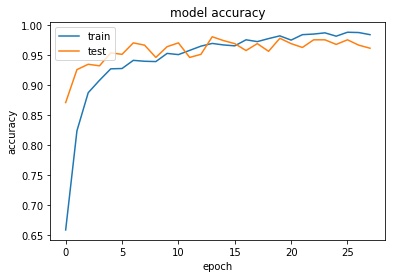

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

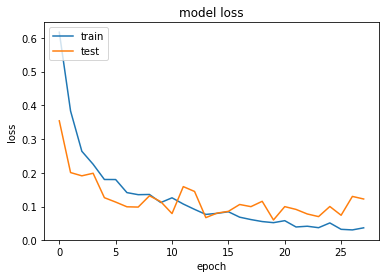

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
test_images = {'cat' : 'C:\\Users\\rafae\\Downloads\\teste\\cat1.jpg',
               'dog' : 'C:\\Users\\rafae\\Downloads\\teste\\dog.jpg'
              }

cat C:\Users\rafae\Downloads\teste\cat1.jpg [[0.]]
dog C:\Users\rafae\Downloads\teste\dog.jpg [[1.]]


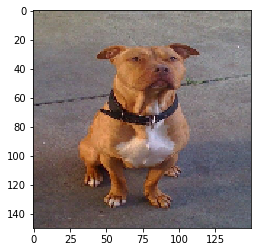

In [22]:
from keras.preprocessing import image

for k,v in test_images.items():
    img_path = v
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = applications.vgg16.preprocess_input(x)
    result = model.predict(x)
    print(k, v, result)
    plt.imshow(img)